In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator


# def plot_km(surv_data, survival_clm="Survival_in_days", group_clm=None, conf = False):

#     if group_clm is None:
#         time, survival_prob, conf_int = kaplan_meier_estimator(
#             surv_data["Status"], surv_data[survival_clm], conf_type="log-log"
#         )

#         plt.step(time, survival_prob, where="post")
#         if conf:
#             plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
#     else:
#         for group_type in np.unique(surv_data[group_clm]):
#             mask = surv_data[group_clm] == group_type
#             time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
#                 surv_data["Status"][mask],
#                 surv_data[survival_clm][mask],
#                 conf_type="log-log",
#             )

#             plt.step(
#                 time_treatment,
#                 survival_prob_treatment,
#                 where="post",
#                 label=f"{group_type}",
#             )
#             plt.legend(loc="best")

#             if conf:
#                 plt.fill_between(
#                     time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post"
#                 )
#     plt.ylim(0, 1)
#     # plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
#     plt.ylabel(r"Survival probability $S(t)$")
#     plt.xlabel(" $t$")
#     plt.title("Kaplan-Meier survival curve")


def plot_km(T, E, pam50, save_path, conf=False):

    # if group_clm is None:
    #     time, survival_prob, conf_int = kaplan_meier_estimator(
    #         E, T, conf_type="log-log"
    #     )

    #     plt.step(time, survival_prob, where="post")
    #     if conf:
    #         plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    # else:
    for group_type in np.unique(pam50):
        mask = pam50 == group_type
        time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
            E[mask],
            T[mask],
            conf_type="log-log",
        )

        plt.step(
            time_treatment,
            survival_prob_treatment,
            where="post",
            label=f"{group_type}",
        )
        plt.legend(loc="best")

        if conf:
            plt.fill_between(
                time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post"
            )

    plt.ylim(0, 1)
    plt.ylabel(r"Survival probability $S(t)$")
    plt.xlabel(r"Days $(t)$")
    plt.title("Kaplan-Meier survival curve")
    plt.savefig(save_path)
    plt.close()

from utils.plots import get_chisq

In [4]:
surv_data = pd.read_csv("./data/gt_data.csv")
surv_data

,Sample_ID,class,Pam50 Subtype,Status,Survival_in_days,Strat_ID
0,A1-A0SF,0,LumA,False,1463,LumA_0
1,A1-A0SJ,0,LumA,False,416,LumA_0
2,A1-A0SK,2,Basal,True,967,Basal_1
3,A1-A0SO,2,Basal,False,852,Basal_0
4,A1-A0SQ,0,LumA,False,554,LumA_0
...,...,...,...,...,...,...
498,GM-A2DM,0,LumA,False,3226,LumA_0
499,GM-A2DN,0,LumA,False,3091,LumA_0
500,GM-A2DO,1,LumB,False,2596,LumB_0
501,GM-A3NY,0,LumA,False,1162,LumA_0


#### KM plots

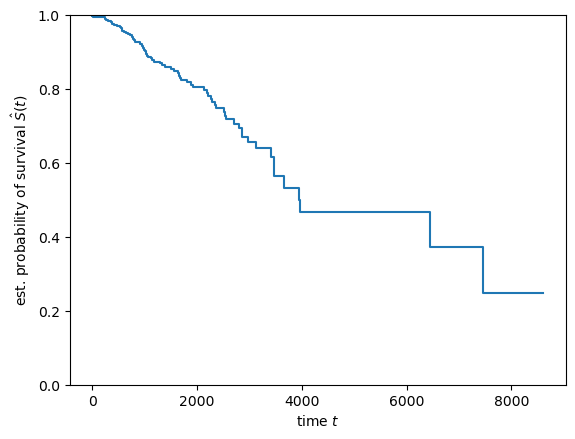

In [11]:
plot_km(surv_data, survival_clm="Survival_in_days")

In [5]:
surv_data["Survival_in_months"] = surv_data["Survival_in_days"]//30

In [10]:
plot_km(surv_data["Survival_in_days"], surv_data["Status"], surv_data["Pam50 Subtype"], "./base_survival_km.jpg")

#### Chi-square

In [9]:
get_chisq(surv_data, surv_data["Pam50 Subtype"])

(11.499351091978287, 0.009310591664479737)

# Results

In [19]:
def combine_results(path, ids, exp_type="test"):

    metrics = None
    for id in ids:
        temp = pd.read_csv(os.path.join(path, id, exp_type,"metrics.csv"))
        temp["model"] = id
        
        if metrics is None:
            metrics = temp
        else:
            metrics = pd.concat([metrics,temp], ignore_index=True)

    metrics.set_index(metrics["model"], drop=True,  inplace = True)
    metrics.sort_index(inplace=True)
    metrics = metrics.drop(columns=["model"])
    
    return metrics


path_results = f"./baseline_results/"
ids = [id for id in os.listdir(path_results) if "study" not in id]

all_res = combine_results(path_results, ids)
all_res.to_csv("./combined_results.csv")
all_res

,acc,f1,chisqr,p_value,c_index
model,,,,,
cls_gat,0.881188,0.870776,16.821761,0.000769,NaN
cls_gcn,0.910891,0.905934,16.580016,0.000862,NaN
cls_mlp,0.841584,0.838129,10.252593,0.016537,NaN
cls_mogcn,0.881188,0.866419,16.976393,0.000715,NaN
mt_gat,0.831683,0.823153,18.427333,0.000359,0.703704
mt_gcn,0.891089,0.889362,16.963565,0.000719,0.671024
mt_mlp,0.930693,0.940881,13.069373,0.004489,0.860566
surv_gat,NaN,NaN,NaN,NaN,0.619826
surv_gcn,NaN,NaN,NaN,NaN,0.652505


In [17]:
kfold_res = combine_results(path_results, ids, "5_fold")
kfold_res.to_csv("./combined_kfold_results.csv")
kfold_res

,mean_acc,sd_acc,mean_f1,sd_f1,mean_chisqr,sd_chsqr,mean_p_value,sd_p_value,mean_best_epoch,sd_best_epoch,mean_c_index,sd_c_index
model,,,,,,,,,,,,
cls_gat,0.928702,0.030014,0.912682,0.043433,14.495902,1.497640,0.002978,0.002300,15.8,2.638181,NaN,NaN
cls_gcn,0.925625,0.032589,0.908471,0.055535,14.658412,1.403607,0.002629,0.001670,20.0,7.071068,NaN,NaN
cls_mlp,0.938029,0.030749,0.917503,0.039097,11.252630,2.027687,0.014994,0.011513,51.6,29.493050,NaN,NaN
cls_mogcn,0.913221,0.036947,0.884037,0.067365,15.547129,1.839441,0.001854,0.001119,125.6,23.804201,NaN,NaN
mt_gat,0.885288,0.052226,0.852849,0.073096,13.005549,2.860847,0.008901,0.008186,51.2,14.837790,0.608811,0.120724
mt_gcn,0.860337,0.036423,0.822748,0.051207,13.031383,1.961949,0.006281,0.004066,18.0,4.774935,0.631285,0.148125
mt_mlp,0.906875,0.025608,0.867631,0.045240,12.894420,1.820391,0.006542,0.004226,14.6,3.611094,0.604220,0.134979
surv_gat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,5.075431,0.603128,0.127982
surv_gcn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,6.603030,0.623709,0.158052


# Predictions

In [17]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
import numpy as np

from sksurv.preprocessing import OneHotEncoder



def get_c_index(data_x, data_y, estimator=CoxPHSurvivalAnalysis()):
    set_config(display="text")  # displays text representation of estimators

    estimator.fit(data_x, data_y)

    coef = pd.Series(estimator.coef_, index=data_x.columns)
    c_index = estimator.score(data_x, data_y)
    print("\nC-index: ", c_index)
    return c_index, coef

def get_score_features(x, y, m=CoxPHSurvivalAnalysis()):
    X = x.values
    n_features = X.shape[1]
    scores = np.empty(n_features)

    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    
    scores = pd.Series(scores, index=x.columns).sort_values(ascending=False)
    print("\nFeature scores:\n", scores)
    return scores

In [2]:
surv_data = pd.read_csv("./data/gt_data.csv")
# surv_data = surv_data[surv_data["Survival_in_days"]<=3959]
surv_data

,Sample_ID,class,Pam50 Subtype,Status,Survival_in_days,Strat_ID
0,A1-A0SF,0,LumA,False,1463,LumA_0
1,A1-A0SJ,0,LumA,False,416,LumA_0
2,A1-A0SK,2,Basal,True,967,Basal_1
3,A1-A0SO,2,Basal,False,852,Basal_0
4,A1-A0SQ,0,LumA,False,554,LumA_0
...,...,...,...,...,...,...
498,GM-A2DM,0,LumA,False,3226,LumA_0
499,GM-A2DN,0,LumA,False,3091,LumA_0
500,GM-A2DO,1,LumB,False,2596,LumB_0
501,GM-A3NY,0,LumA,False,1162,LumA_0


In [3]:
def get_bool_mask(df_gt, df_ids):
    return np.array(df_gt["Sample_ID"].isin(df_ids))

train_mask = get_bool_mask(surv_data, pd.read_csv("./data/train_strat_id.csv")["Sample_ID"])
test_mask = get_bool_mask(surv_data, pd.read_csv("./data/test_strat_id.csv")["Sample_ID"])

In [4]:
train_max = surv_data[train_mask]["Survival_in_days"].max()
train_max

# brier_times = np.arange(surv_data[test_mask]["Survival_in_days"].min(), surv_data[test_mask]["Survival_in_days"].max())
brier_times = np.arange(surv_data[test_mask]["Survival_in_days"].min(), train_max)
brier_times

array([  10,   11,   12, ..., 7103, 7104, 7105])

In [5]:
surv_struct = np.array(list(zip(surv_data["Status"].to_list(), surv_data["Survival_in_days"].to_list())), dtype=[("Status", "?"), ("Survival_in_days", "<f8")])
len(surv_struct)
# mask = train_mask.astype(int).tolist()
# cut_mask = np.isin(np.arange(len(train_mask)), surv_data.index.to_list())

# len(train_mask[cut_mask])

503

In [6]:
data_x = pd.read_csv("./data/latent_data.csv")
data_x = data_x.loc[data_x["Sample_ID"].isin(surv_data["Sample_ID"])]
data_x = data_x.iloc[:,1:]
# data_x = data_x[train_mask]
len(data_x)

503

In [7]:
data_y = surv_data[["Status", "Survival_in_days"]].to_records(index=False)
# data_y = data_y[train_mask[cut_mask]]
len(data_y)

503

In [9]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator=CoxPHSurvivalAnalysis()
estimator.fit(data_x[train_mask], data_y[train_mask])
estimate = estimator.predict(data_x[test_mask])

In [26]:
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, integrated_brier_score

# eval_E = surv_data["Status"][test_mask].to_numpy()
# eval_T = surv_data["Survival_in_days"][test_mask].to_numpy()

# # print(eval_E)
# # print(eval_T)

# # order = np.argsort(eval_T)
# # eval_T = eval_T[order]
# # eval_E = eval_E[order]
# # print(eval_T)
# # estimate = estimate[order]
# # print(estimate)

# c_index = concordance_index_censored(eval_E,eval_T,estimate)
# print(c_index)

# c_index = concordance_index_ipcw(surv_struct[train_mask], surv_struct[test_mask],estimate, tau=train_max)
# print(c_index)

surv_fun = estimator.predict_survival_function(data_x[test_mask])
preds = np.asarray([[fn(t) for t in brier_times] for fn in surv_fun])
preds

array([StepFunction(x=array([   1,    5,    9,   10,   21,   26,   30,   49,   59,   78,   79,
                84,   92,  118,  134,  149,  170,  186,  200,  210,  217,  225,
               231,  239,  255,  266,  273,  288,  289,  302,  304,  313,  317,
               320,  322,  332,  337,  339,  343,  345,  358,  362,  363,  365,
               366,  373,  375,  376,  377,  379,  381,  383,  385,  393,  394,
               395,  396,  397,  398,  403,  409,  410,  416,  425,  426,  430,
               431,  439,  441,  447,  448,  450,  458,  461,  463,  466,  468,
               470,  472,  475,  477,  480,  496,  499,  502,  503,  506,  508,
               509,  513,  519,  521,  526,  528,  530,  532,  533,  538,  541,
               547,  548,  552,  554,  563,  566,  571,  575,  576,  577,  584,
               585,  590,  591,  595,  606,  608,  611,  614,  616,  631,  639,
               643,  660,  664,  672,  677,  678,  679,  683,  694,  698,  702,
               703,  709,

In [142]:
c_index = concordance_index_ipcw(surv_struct[train_mask], surv_struct[test_mask],estimate, tau=train_max)
c_index

(0.7541162526478246, 349, 110, 0, 1)

In [29]:
brier = integrated_brier_score(surv_struct[test_mask], surv_struct[test_mask],preds, brier_times)
# print("\nC-index: ", c_index)
print("\nBrier: ", brier)


Brier:  0.38784874803760727


In [28]:
import scipy.optimize as opt

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd

from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sksurv.datasets import load_flchain, load_gbsg2
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv

set_config(display="text")  # displays text representation of estimators
plt.rcParams["figure.figsize"] = [7.2, 4.8]

def generate_marker(n_samples, hazard_ratio, baseline_hazard, rnd):
    # create synthetic risk score
    X = rnd.randn(n_samples, 1)

    # create linear model
    hazard_ratio = np.array([hazard_ratio])
    logits = np.dot(X, np.log(hazard_ratio))

    # draw actual survival times from exponential distribution,
    # refer to Bender et al. (2005), https://doi.org/10.1002/sim.2059
    u = rnd.uniform(size=n_samples)
    time_event = -np.log(u) / (baseline_hazard * np.exp(logits))

    # compute the actual concordance in the absence of censoring
    X = np.squeeze(X)
    actual = concordance_index_censored(np.ones(n_samples, dtype=bool), time_event, X)
    return X, time_event, actual[0]


def generate_survival_data(n_samples, hazard_ratio, baseline_hazard, percentage_cens, rnd):
    X, time_event, actual_c = generate_marker(n_samples, hazard_ratio, baseline_hazard, rnd)

    def get_observed_time(x):
        rnd_cens = np.random.RandomState(0)
        # draw censoring times
        time_censor = rnd_cens.uniform(high=x, size=n_samples)
        event = time_event < time_censor
        time = np.where(event, time_event, time_censor)
        return event, time

    def censoring_amount(x):
        event, _ = get_observed_time(x)
        cens = 1.0 - event.sum() / event.shape[0]
        return (cens - percentage_cens) ** 2

    # search for upper limit to obtain the desired censoring amount
    res = opt.minimize_scalar(censoring_amount, method="bounded", bounds=(0, time_event.max()))

    # compute observed time
    event, time = get_observed_time(res.x)

    # upper time limit such that the probability
    # of being censored is non-zero for `t > tau`
    tau = time[event].max()
    y = Surv.from_arrays(event=event, time=time)
    mask = time < tau
    X_test = X[mask]
    y_test = y[mask]

    return X_test, y_test, y, actual_c


def simulation(n_samples, hazard_ratio, n_repeats=100):
    measures = (
        "censoring",
        "Harrel's C",
        "Uno's C",
    )
    data_mean = {}
    data_std = {}
    for measure in measures:
        data_mean[measure] = []
        data_std[measure] = []

    rnd = np.random.RandomState(seed=987)
    # iterate over different amount of censoring
    for cens in (0.1, 0.25, 0.4, 0.5, 0.6, 0.7):
        data = {
            "censoring": [],
            "Harrel's C": [],
            "Uno's C": [],
        }

        # repeaditly perform simulation
        for _ in range(n_repeats):
            # generate data
            X_test, y_test, y_train, actual_c = generate_survival_data(
                n_samples, hazard_ratio, baseline_hazard=0.1, percentage_cens=cens, rnd=rnd
            )

            print(y_train)

            # estimate c-index
            c_harrell = concordance_index_censored(y_test["event"], y_test["time"], X_test)
            c_uno = concordance_index_ipcw(y_train, y_test, X_test)

            # save results
            data["censoring"].append(100.0 - y_test["event"].sum() * 100.0 / y_test.shape[0])
            data["Harrel's C"].append(actual_c - c_harrell[0])
            data["Uno's C"].append(actual_c - c_uno[0])

        # aggregate results
        for key, values in data.items():
            data_mean[key].append(np.mean(data[key]))
            data_std[key].append(np.std(data[key], ddof=1))

    data_mean = pd.DataFrame.from_dict(data_mean)
    data_std = pd.DataFrame.from_dict(data_std)
    return data_mean, data_std


def plot_results(data_mean, data_std, **kwargs):
    index = pd.Index(data_mean["censoring"].round(3), name="mean percentage censoring")
    for df in (data_mean, data_std):
        df.drop("censoring", axis=1, inplace=True)
        df.index = index

    ax = data_mean.plot.bar(yerr=data_std, **kwargs)
    ax.set_ylabel("Actual C - Estimated C")
    ax.yaxis.grid(True)
    ax.axhline(0.0, color="gray")

hazard_ratio = 2.0
ylim = [-0.035, 0.035]
mean_1, std_1 = simulation(5, hazard_ratio, n_repeats=5)
plot_results(mean_1, std_1, ylim=ylim)

[(False, 15.90518783) (False, 20.72693388) ( True,  2.92249924)
 ( True,  0.40593736) ( True, 10.46175524)]
[( True, 2.15020397) ( True, 1.09311081) ( True, 0.83327553)
 (False, 2.72750126) (False, 2.1206729 )]
[(False, 4.0629358 ) ( True, 3.391867  ) (False, 4.46233353)
 (False, 4.03383913) (False, 3.13637007)]


ValueError: Need a minimum of two samples